# Setting up the modules 

In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr, describe
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model


from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, initialize_vars
from models.train_models import *
from utils.utils import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# import cloze sentences 

In [6]:
try:
    from google import colab
    IN_COLAB = True
    # mount GoogleDrive for data and external resources
    colab.drive.mount('/content/drive')

    # download and install additional libraries
    !pip install keras_tqdm -q
    !pip install livelossplot -q
    
    
#     sys.path.append('./drive/My Drive/Colab Notebooks')  # append colab directory to Python kernel's path
    df_cloze = pd.read_pickle('./drive/My Drive/Colab Notebooks/dataset/cloze_df_scores_all3.pickle')
except:
    IN_COLAB = False
    df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle') # enter the local location of DSCoVAR sentence data

## preprocessing model inputs

In [7]:
FILTERS = '"#$%&()*+/:;=@[\\]^_`{|}~\t\n'

In [8]:
[i for i in range(3)]

[0, 1, 2]

In [9]:
MAX_SEQ_LEN = 160
def proc_sentences(df, col_sentence, col_targ):
    sentences = []
#     li_mask_LH = []
#     li_mask_RH = []
    li_mask_cntx = []
    li_mask_targ = []
#     li_targ = []
#     li_targ_idx = []
    li_sent_len = []
    li_sent_pad = []
    for i in range(df.shape[0]):
        sent = df.iloc[i][col_sentence]
        
        targ = None
        if(col_targ):
            targ = df.iloc[i][col_targ]
        else:
            targ = "<UNK>"
        
        sent = sent.replace("______", targ)
        sent = sent.replace("<BOS>", "").replace(".", " .").replace(",", " ,").replace("!", " !").replace(",?", " ?").replace("'s", " 's")
        sent_tok = text_to_word_sequence(sent, lower=False, filters=FILTERS)
        sent_pad = pad_sequences([sent_tok], maxlen=MAX_SEQ_LEN, dtype='object', padding='post', value=[""])       
        targ_idx = np.where(targ==sent_pad[0])[0][0]
        
        mask_targ = [0]*(MAX_SEQ_LEN)
        mask_targ[targ_idx] = 1
#         mask_LH = [0]*(MAX_SEQ_LEN)
#         mask_RH = [0]*(MAX_SEQ_LEN)
        mask_cntx = [0]*(MAX_SEQ_LEN)
        for i in range(targ_idx):
            mask_cntx[i] = 1
        if(col_targ):
            for i in range(targ_idx, len(sent_tok)):
                mask_cntx[i] = 1
        else:
            for i in range(targ_idx+1, len(sent_tok)):
                mask_cntx[i] = 1
    
#         for i in range(targ_idx):
#             mask_LH[i] = 1
#         for i in range(targ_idx+1, len(sent_tok)):
#             mask_RH[i] = 1
        
        sent_len = len(sent_tok)
        
#         li_targ.append(targ)
#         li_targ_idx.append(targ_idx)
        li_sent_len.append(sent_len)
        li_sent_pad.append(list(sent_pad)[0])
        li_mask_cntx.append(mask_cntx)
        li_mask_targ.append(mask_targ)
#         li_mask_LH.append(mask_LH)
#         li_mask_RH.append(mask_RH)
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad), np.array(li_targ)]
#     sentences = [np.array(li_targ_idx), np.array(li_sent_len), np.array(li_sent_pad)]
#     sentences = [np.array(li_sent_len), np.array(li_sent_pad), # np.array(li_targ_idx),
#                  np.array(li_mask_LH), np.array(li_mask_RH)] #, np.sum((li_mask_LH, li_mask_RH), axis=0)]
    sentences = [np.array(li_sent_len), np.array(li_sent_pad), np.array(li_mask_cntx), np.array(li_mask_targ)]
    return(sentences)

In [10]:
sentences_wttarg = proc_sentences(df_cloze, 'sentence', 'syn1')
sentences_notarg = proc_sentences(df_cloze, 'sentence', None)

In [44]:
# import pickle
# with open("dscovar_sentences_wttarg_elmo_max150.pickle", "wb") as f: pickle.dump(sentences_wttarg, f)
# with open("dscovar_sentences_notarg_elmo_max150.pickle", "wb") as f: pickle.dump(sentences_notarg, f)
# with open("dscovar_sentences_notarg_elmo_max160.pickle", "wb") as f: pickle.dump(sentences_notarg, f)

In [12]:
len(sentences_wttarg[1][0])

160

In [45]:
len(sentences_notarg[0])

1783

In [13]:
sentences_notarg

[array([11, 11, 12, ..., 14, 12, 16]),
 array([['A', '<UNK>', 'emerged', ..., '', '', ''],
        ['A', 'bohemian', 'is', ..., '', '', ''],
        ['A', 'bunch', 'of', ..., '', '', ''],
        ...,
        ['You', 'will', 'not', ..., '', '', ''],
        ["You'll", 'find', 'what', ..., '', '', ''],
        ['Your', 'plan', "'s", ..., '', '', '']], dtype=object),
 array([[1, 0, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [14]:
df_cloze.columns

Index(['Unnamed: 0', 'index', 'cloze_resp', 'sentID_GM', 'sentence', 'targ',
       'targ_POS', 'cloze_resp_len', 'ent_elmo', 'ent_cloze', 'bert_score',
       'glove_score', 'Unnamed: 0.1', 'sent_idx', 'scores', 'scores_sum',
       'scores_avg', 'scores_std', 'scores_avg_rank', 'elmo_score', 'sent_len',
       'targ_loc', 'targ_loc_before', 'targ_loc_end', 'targ_loc_rel', 'syn1',
       'syn2', 'syn3'],
      dtype='object')

In [15]:
mm_scaler = MinMaxScaler()

resp_scores = mm_scaler.fit_transform(df_cloze[['ent_cloze', 
                                                'elmo_score', 'bert_score', 'glove_score',
                                                'scores_sum', 'sent_len']])
resp_lex = resp_scores[:, 0]
resp_lex = 1-resp_lex # reversing the direction: high score for high informative sentences

resp_lmo = resp_scores[:, 1]
resp_brt = resp_scores[:, 2]
resp_glv = resp_scores[:, 3]
resp_bws = resp_scores[:, 4]
sent_len = resp_scores[:, 5]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
# with open("resp_bws.pickle", "wb") as f: pickle.dump(resp_bws, f)

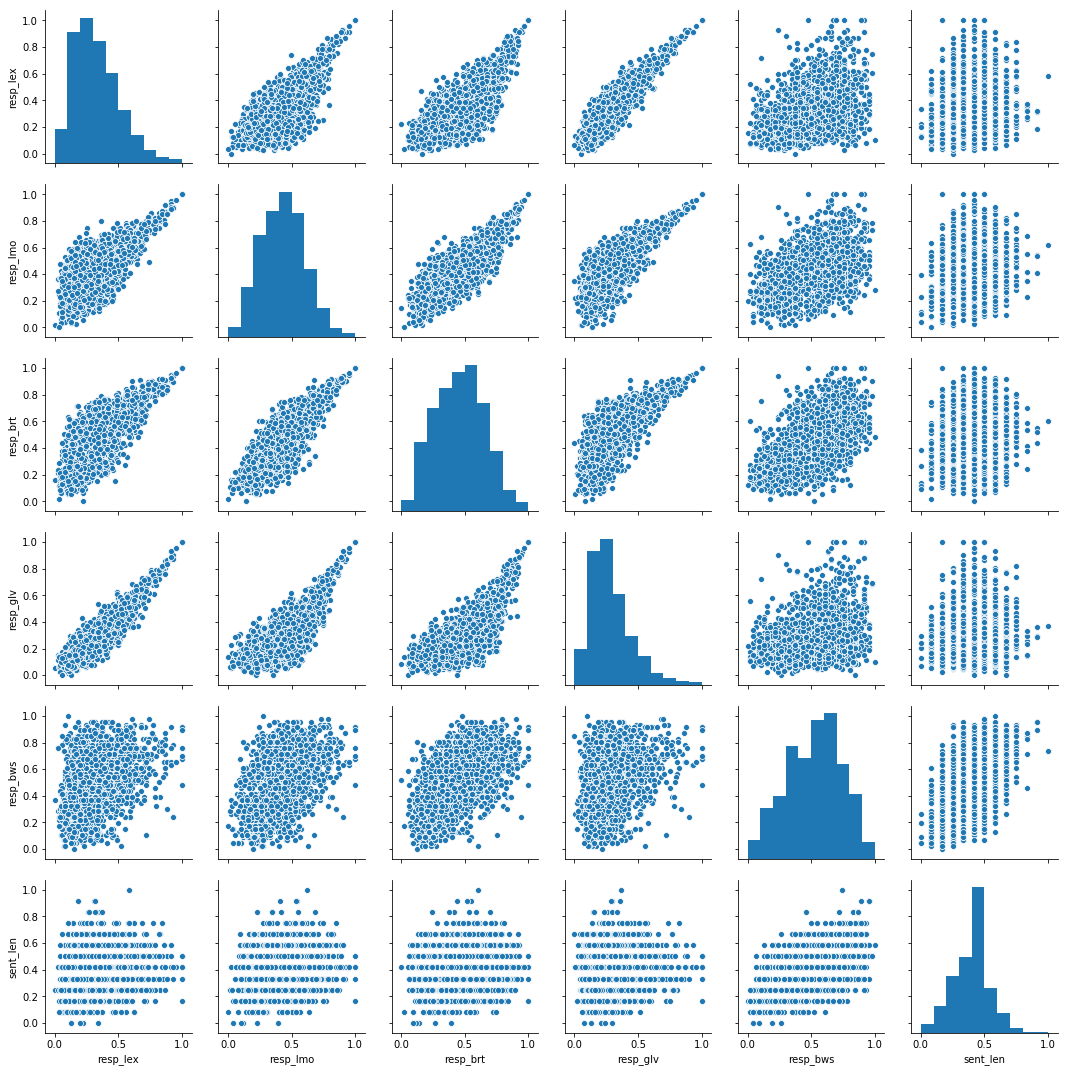

In [17]:
sns.pairplot(pd.DataFrame({"resp_lex":resp_lex, 
                           "resp_lmo":resp_lmo, "resp_brt":resp_brt, "resp_glv":resp_glv, 
                           "resp_bws":resp_bws,
                           "sent_len":sent_len}))

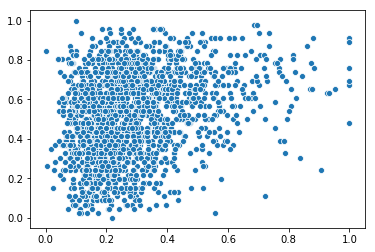

In [18]:
sns.scatterplot(resp_glv, resp_bws)

In [35]:
np.reshape([resp_bws], len(resp_bws), 1)

array([0.45652174, 0.52173913, 0.5       , ..., 0.60869565, 0.43478261,
       0.58695652])

In [39]:
sentences_notarg+[resp_bws]

[array([11, 11, 12, ..., 14, 12, 16]),
 array([['A', '<UNK>', 'emerged', ..., '', '', ''],
        ['A', 'bohemian', 'is', ..., '', '', ''],
        ['A', 'bunch', 'of', ..., '', '', ''],
        ...,
        ['You', 'will', 'not', ..., '', '', ''],
        ["You'll", 'find', 'what', ..., '', '', ''],
        ['Your', 'plan', "'s", ..., '', '', '']], dtype=object),
 array([[1, 0, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([0.45652174, 0.52173913, 0.5       , ..., 0.60869565, 0.43478261,
        0.58695652])]

# ELMo + Attention model
- 1emb
- lr: 1e-3
- batch: 16
- iter: 5
- TODO: use validation set (from the training part) to select the hyperparameter?

## 1-1. No tune, no attention

In [18]:
gkf1 = GroupKFold(n_splits=10) ## target words

In [19]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_nt_na = train_elmomod_cv(sentences_notarg, resp_glv, gkf_split,
                                       False, False, False,
                                       None, None, 
                                       MAX_SEQ_LEN, 1e-3, 5, 16)

In [23]:
np.save("elmo_result_nt_na_out_glv.npy", [result_nt_na['test_evals'], result_nt_na['test_trues']])

## 1-2. No tune, /w attention

In [24]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_nt_wa = train_elmomod_cv(sentences_notarg, resp_glv, gkf_split,
                                       False, True, False,
                                       None, None, 
                                       MAX_SEQ_LEN, 1e-3, 5, 16)

In [25]:
np.save("elmo_result_nt_wa_out_glv.npy", [result_nt_wa['test_evals'], result_nt_wa['test_trues']])

## 2-1. fine tune, no attention

In [19]:
gkf1 = GroupKFold(n_splits=10) ## target words

In [20]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_ft_na = train_elmomod_cv(sentences_notarg, resp_glv, gkf_split,
                                       True, False, False,
                                       None, None, 
                                       MAX_SEQ_LEN, 1e-3, 5, 16)

In [21]:
np.save("elmo_result_ft_na_out_glv.npy", [result_ft_na['test_evals'], result_ft_na['test_trues']])

## 2-2. fine tune, /w attention

In [22]:
gkf_split = gkf1.split(df_cloze['sentence'], groups=df_cloze['targ'])

result_ft_wa = train_elmomod_cv(sentences_notarg, resp_glv, gkf_split,
                                       True, True, False,
                                       None, None, 
                                       MAX_SEQ_LEN, 1e-3, 5, 16)

In [23]:
np.save("elmo_result_ft_wa_out_glv.npy", [result_ft_wa['test_evals'], result_ft_wa['test_trues']])

# Best full model 

In [24]:
K.clear_session()
sess = tf.Session()

model_elmo = build_model_elmo(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False, lr=1e-3)
initialize_vars(sess)

In [25]:
model_elmo.fit(sentences_notarg, resp_glv, 
               epochs=5, batch_size=16, verbose=0,
               callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=False)])

In [26]:
model_elmo.save_weights("./model_weights/finetune/elmo/1emb/model_elmo_notarg_wtattn_glv_full_i5_b16_lr1e-03.tf")